In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from dataset import DataSet
import pandas as pd
from torch import nn
from torch import optim
from sklearn.decomposition import PCA
from tqdm import tqdm
import time
import torch.nn.functional as F

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload

In [3]:
np.random.seed(2) 
torch.manual_seed(2)

## load a checkpoint & dataset the network trained on

In [5]:
lcs = utils.get_data('../../datasets/ZTF_g', sep=',', start_col=1, batch_size=1, min_length=1, n_union_tp=3500, num_resamples=0,shuffle=True, split=1.0, extend=0)


validated 3408 files out of 3408 for band='g'
created union_tp attribute of length 3500
dataset created w/ shape (2559, 1, 1974, 3)
train size: 2559, valid size: 0, test size: 0


In [6]:
net, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('../checkpoints/ZTF_g0.668415367603302.h5', lcs.data_obj)


=> loading checkpoint '../checkpoints/ZTF_g0.668415367603302.h5'
Namespace(n_union_tp=3500, data_folder='datasets/ZTF_g', checkpoint='datasets/ZTF_g0.7037358283996582.h5', start_col=1, inc_errors=False, print_at=1, embed_time=128, enc_num_heads=16, latent_dim=64, mixing='concat', num_ref_points=16, rec_hidden=128, width=512, save_at=30, patience=100, early_stopping=False, niters=20000, frac=0.5, batch_size=2, mse_weight=5.0, dropout=0.0, num_resamples=0, lr=1e-06, scheduler=False, warmup=4000, kl_zero=False, kl_annealing=True, net='hetvae', device='mps', const_var=False, var_per_dim=False, std=0.1, seed=2, save=True, k_iwae=1)


# Plot Learning curves

[<AxesSubplot:title={'center':'Learning Curves for g model'}>
 <AxesSubplot:> <AxesSubplot:xlabel='Epoch'>]


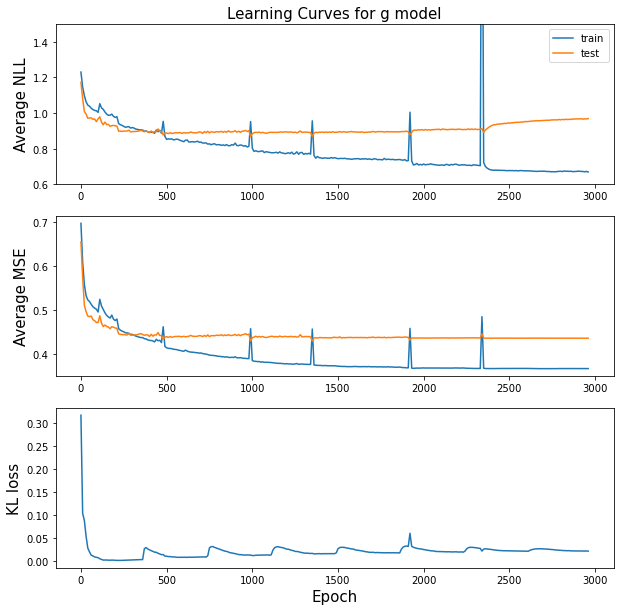

In [8]:
train_l = np.array(train_loss)
test_l = np.array(test_loss)
fs = 15
fig, ax = plt.subplots(3, figsize=(10,10))
ax[0].set_title('Learning Curves for g model',fontsize=fs)
ax[2].set_xlabel('Epoch',fontsize=fs)
print(ax)
## NLL
x = np.arange(0,len(train_loss)*10,10) 
ax[0].plot(x,train_l[:,0], label='train')
ax[0].plot(x,test_l[:,0], label='test')
ax[0].set_ylim(0.6,1.5)
ax[0].legend(loc="upper right")
ax[0].set_ylabel('Average NLL',fontsize=fs)
## MSE
ax[1].plot(x, train_l[:,1], label='train')
ax[1].plot(x, test_l[:,1], label='test')
ax[1].set_ylabel('Average MSE',fontsize=fs)
## KL Annealing
ax[2].plot(x,train_l[:,2])
ax[2].set_ylabel('KL loss',fontsize=fs)

plt.savefig('../img/glc')

In [39]:
print(train_l[-1],test_l[-1])

[0.66841537 0.36586908 0.02206035] [0.96878964 0.43517342]


## choose a dataset you want to make predictions with 

In [55]:
t1=time.time()
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device='mps')
t2=time.time()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2559/2559 [00:26<00:00, 96.76it/s]


In [56]:
print(qzs.shape, disc_path.shape)

(2559, 2, 16, 64) (2559, 16, 64)


In [7]:
utils.save_qzs(qzs, obj_names=lcs.valid_files_df.index, bands=test.bands,save_folder='qzs_all' )

qzs[i].shape=(1024, 2) for obj_names[i]='155301.00+224451.5' saved to qzs_all/155301.00+224451.5/155301.00+224451.5_qz.dat
qzs[i].shape=(1024, 2) for obj_names[i]='142604.91+563402.7' saved to qzs_all/142604.91+563402.7/142604.91+563402.7_qz.dat
qzs[i].shape=(1024, 2) for obj_names[i]='170729.48+321937.6' saved to qzs_all/170729.48+321937.6/170729.48+321937.6_qz.dat
qzs[i].shape=(1024, 2) for obj_names[i]='105222.28+271941.2' saved to qzs_all/105222.28+271941.2/105222.28+271941.2_qz.dat
qzs[i].shape=(1024, 2) for obj_names[i]='214307.65+103616.7' saved to qzs_all/214307.65+103616.7/214307.65+103616.7_qz.dat
qzs[i].shape=(1024, 2) for obj_names[i]='110007.99+613425.5' saved to qzs_all/110007.99+613425.5/110007.99+613425.5_qz.dat
qzs[i].shape=(1024, 2) for obj_names[i]='011419.51+190909.4' saved to qzs_all/011419.51+190909.4/011419.51+190909.4_qz.dat
qzs[i].shape=(1024, 2) for obj_names[i]='164728.87+401121.6' saved to qzs_all/164728.87+401121.6/164728.87+401121.6_qz.dat
qzs[i].shape=(10

In [42]:
num_ref_points = 16 #args.num_ref_points
latent_dim = 64     #args.latent_dim
l = len(lcs.dataset)

## Load the saved qzs (if you need to)

In [8]:
## get qzs from folder, ensuring sure they're ordered the same as the loaded dataset
qzs = np.zeros((l,num_ref_points*latent_dim,2))
folder = 'qzs_all'
for obj in os.listdir(folder):
    qz = pd.read_csv(os.path.join(folder, obj,f'{obj}_qz.dat'), sep=' ',header=None).to_numpy()
    i = test.valid_files_df.index.get_loc(obj)
    qzs[i] = qz

## Sample qZ

In [93]:
n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:])
### uncomment USE MEAN OF QZ instead
# zs = qzs[:,0,:,:].reshape(qzs.shape[0],-1)

In [76]:
lcs.set_target_x(100)

In [48]:
tr = int(l * 0.9) # train-test split

In [89]:
means, stds, target_tp = utils.decode(net, zs[:10], disc_path[:10], lcs.target_x[:10])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.27it/s]


In [ ]:
# to get interps ...decode each sample, avg  

In [ ]:
# decode each set of samples from dataset 
for z in zs:
    means, stds, target_tp = utils.decode()

In [ ]:
# 

In [49]:
RS = 20150101
pca = PCA(n_components=3, random_state=RS)

### pcall

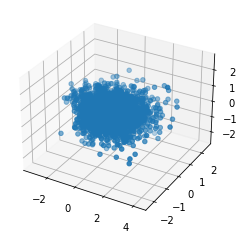

In [50]:
pca3d = pca.fit_transform(zs) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2])

In [51]:
pca.explained_variance_ratio_

array([0.00993909, 0.00347441, 0.00283113])

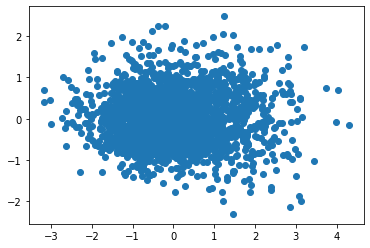

In [52]:
plt.scatter(pca3d[:,0],pca3d[:,1])

In [156]:
## amount missing 
nonmiss = test.dataset[:,:,:,1].sum(axis=2) > 0
mis2 = (nonmiss.sum(axis=1) == 1)
mis1 = (nonmiss.sum(axis=1) == 2)
mis0 = (nonmiss.sum(axis=1) == 0)


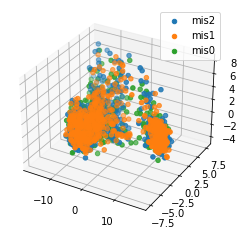

In [158]:
RS = 20150101
pca3d = PCA(n_components=3, random_state=RS).fit_transform(zs) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[mis2,0],pca3d[mis2,1],pca3d[mis2,2], label='mis2')
ax.scatter(pca3d[mis1,0],pca3d[mis1,1],pca3d[mis1,2], label='mis1')
ax.scatter(pca3d[mis0,0],pca3d[mis0,1],pca3d[mis0,2], label='mis0')
ax.legend()

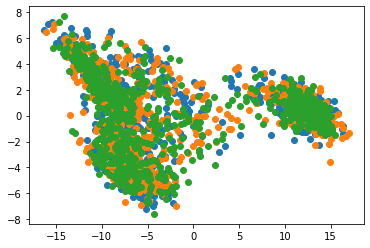

In [159]:
plt.scatter(pca3d[mis2,0],pca3d[mis2,1], label='mis2')
plt.scatter(pca3d[mis1,0],pca3d[mis1,1], label='mis1')
plt.scatter(pca3d[mis0,0],pca3d[mis0,1], label='mis0')
ax.legend()

In [172]:
misg = nonmiss[:,2]
misr = nonmiss[:,0]
misi = nonmiss[:,1]

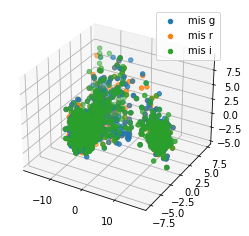

In [173]:
RS = 20150101
pca3d = PCA(n_components=3, random_state=RS).fit_transform(zs) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[misg,0],pca3d[misg,1],pca3d[misg,2], label='mis g')
ax.scatter(pca3d[misr,0],pca3d[misr,1],pca3d[misr,2], label='mis r')
ax.scatter(pca3d[misi,0],pca3d[misi,1],pca3d[misi,2], label='mis i')
ax.legend()

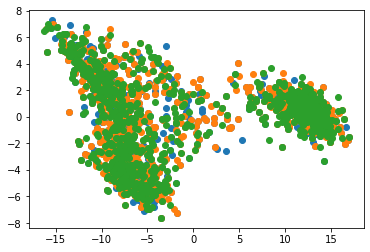

In [174]:
plt.scatter(pca3d[misg,0],pca3d[misg,1], label='misg')
plt.scatter(pca3d[misr,0],pca3d[misr,1], label='misr')
plt.scatter(pca3d[misi,0],pca3d[misi,1], label='misi')
ax.legend()

## Set up PCA grid

(array([ 75., 380., 676., 351., 119.,  52.,  41., 108., 688.]),
 array([-16.26348712, -12.94468119,  -9.62587526,  -6.30706934,
         -2.98826341,   0.33054252,   3.64934845,   6.96815437,
         10.2869603 ,  13.60576623]),
 <BarContainer object of 9 artists>)

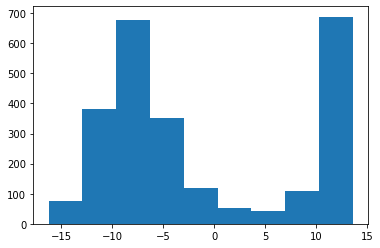

In [192]:
r1,r2 = np.min(pca3d[:,0]), np.max(pca3d[:,0])
bins = np.arange(r1,r2, step=(r2-r1)/10)
plt.hist(pca3d[:,0],bins=bins)

In [194]:
bin_i = np.digitize(pca3d[:,0],bins=bins)

In [199]:
disc_path.shape

(2683, 16, 64)

In [204]:
### avg qzs and disc encodings for each bin in the space 
avgs = [(qzs[bin_i==i, :,:,:].mean(0),disc_path[bin_i==i,:,:].mean(0)) for i in range(1,len(bins)+1)]

In [ ]:
# reconstruct
# space is based on samples? avg samples to decode then ? 



# Visualize

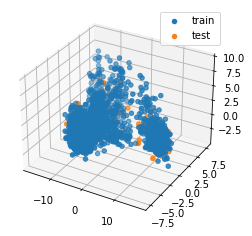

In [160]:
RS = 20150101
pca3d = PCA(n_components=3, random_state=RS).fit_transform(zs) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[:tr,0],pca3d[:tr,1],pca3d[:tr,2], label='train')
ax.scatter(pca3d[tr:,0],pca3d[tr:,1],pca3d[tr:,2], label='test')
ax.legend()

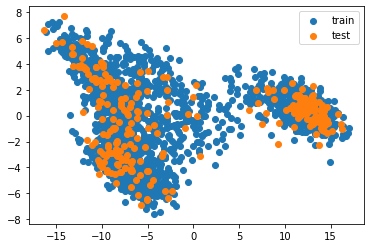

In [161]:
plt.scatter(pca3d[:tr,0],pca3d[:tr,1],label='train')
plt.scatter(pca3d[tr:,0],pca3d[tr:,1],label='test')
plt.legend()

In [ ]:
# what is this wing thing? ones w/ missing light curves? 

# get anomolous indexes 

In [ ]:
from sklearn.ensemble import IsolationForest as IF
forest = IsolationForest(random_state=0, n_estimators=500)
forest.fit(latent)
anom_preds = IF.predict(latent)
anom_IF = IF_preds < 0

## Get normalized excess variance from dataset

In [26]:
## redo so data is not normalized when we set it!
folder = '../datasets/ZTF_rm'
ds = DataSet(name=folder)
[ds.add_band(os.path.join(folder, band_folder)) for band_folder in os.listdir(folder)] 
ds.filter()
ds.prune_outliers()

validated 9 files out of 9 for band='r'
validated 10 files out of 10 for band='i'
validated 10 files out of 10 for band='g'


In [27]:
ds.set_sigma_nxs()
sigma_nxs = ds.sigma_nxs

(array([3., 1., 0., 3., 0., 0., 0., 0., 0., 1.]),
 array([1.33188057e-05, 4.21839830e-05, 7.10491604e-05, 9.99143378e-05,
        1.28779515e-04, 1.57644693e-04, 1.86509870e-04, 2.15375047e-04,
        2.44240225e-04, 2.73105402e-04, 3.01970580e-04]),
 <BarContainer object of 10 artists>)

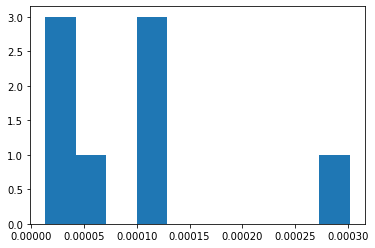

In [29]:
plt.hist(ds.sigma_nxs[:,0])

In [73]:
zs.astype(np.float32)


array([[ 1.0663006 ,  0.5424855 ,  0.5489338 , ...,  0.42343208,
         0.07412038,  0.48898065],
       [ 0.7588833 ,  0.76511943,  0.7991115 , ...,  0.8172763 ,
         0.89509565,  0.731223  ],
       [ 0.47008333,  0.5250734 , -0.10008571, ...,  0.90969175,
         0.8188921 ,  0.6818519 ],
       ...,
       [ 0.99016714,  0.42186648, -0.00330138, ...,  0.79058796,
         1.008503  ,  0.99297416],
       [ 0.4657292 ,  0.37363565,  0.3639895 , ...,  0.89767724,
         0.73204935,  0.5467866 ],
       [ 0.9601127 ,  0.68496203,  1.0323727 , ...,  0.89339083,
         0.9032893 ,  0.8300626 ]], dtype=float32)

## Set Up

In [120]:
#indexes we want, 7 is test.split_index
gtz = sigma_nxs[:7,2].nonzero()[0]
labels = sigma_nxs[gtz,2] # - lcs.sigma_nxs[gtz,2].min()

zs = zs.astype(np.float32)
labels = labels.astype(np.float32)

dataset = [[zs[i,:], labels[i]] for i in range(len(labels))]
trainset = torch.utils.data.DataLoader(dataset, batch_size=8)

In [121]:
# here they're all nonnegative, that could change, also there are none missing
sigma_nxs

array([[3.01970580e-04, 0.00000000e+00, 3.77110287e-04],
       [1.11090433e-04, 7.16103498e-05, 1.77283048e-04],
       [1.33188057e-05, 0.00000000e+00, 2.58973749e-05],
       [1.04515019e-04, 9.17989797e-05, 2.23061835e-04],
       [1.04007834e-04, 3.51376128e-05, 1.47914229e-04],
       [3.07221287e-05, 0.00000000e+00, 4.10349036e-05],
       [3.70563645e-05, 3.70100014e-05, 7.74585458e-05],
       [4.73070489e-05, 5.84848474e-05, 7.47757837e-05]])

In [2]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, INPUT_DIM):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(INPUT_DIM, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

NameError: name 'nn' is not defined

In [3]:
device = torch.device('mps')
INPUT_DIM = zs.shape[1]
model = MLP(INPUT_DIM)
optimizer = optim.Adam(model.parameters())

NameError: name 'torch' is not defined

In [4]:
def my_loss(pred, target):
    r2 = ((target - pred)**2) /(target - 0.00015282289)**2
    loss = 1 - r2
    return loss
criterion = nn.MSELoss()

NameError: name 'nn' is not defined

In [205]:
model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [210]:
EPOCHS = 10
for epoch in range(EPOCHS):
    epoch_loss = 0
    model.train()
    for (x, y) in trainset:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x).squeeze()
        loss = criterion(y_pred, y)
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(x)
    print(epoch_loss)
    


0.0009254938922822475
0.0009254938922822475
0.0009254938922822475
0.0009254938922822475
0.0009254938922822475
0.0009254938922822475
0.0009254938922822475
0.0009254938922822475
0.0009254938922822475
0.0009254938922822475


In [219]:
x

tensor([[ 1.0663,  0.5425,  0.5489,  ...,  0.4234,  0.0741,  0.4890],
        [ 0.7589,  0.7651,  0.7991,  ...,  0.8173,  0.8951,  0.7312],
        [ 0.4701,  0.5251, -0.1001,  ...,  0.9097,  0.8189,  0.6819],
        ...,
        [ 0.9902,  0.4219, -0.0033,  ...,  0.7906,  1.0085,  0.9930],
        [ 0.4657,  0.3736,  0.3640,  ...,  0.8977,  0.7320,  0.5468],
        [ 0.9601,  0.6850,  1.0324,  ...,  0.8934,  0.9033,  0.8301]],
       device='mps:0')

In [ ]:
# large NLL anomolies
std = np.std(nlls)
mu = np.mean(nlls)
anom_nlls = (nlls>mu+std) | (nlls<mu-std)


# Isolation Forest
IF = IsolationForest(random_state=0, n_estimators=500)
IF.fit(latent)
IF_preds = IF.predict(latent)
anom_IF = IF_preds < 0

anoms = anom_IF | anom_nlls